# Part 0: Setting everything up

This lab is done in Google Colab. Google Colab lets you run sections of Python code at a time. If you make a change to the code and want to re-run it, you can re-run just the section you changed.

Google Colab runs all of your code on Google's computers, not your own. This means the code may run a little faster, but your work may be lost if you close this window and end the session. If you saved your code, you can just re-run every code section and get to the point where you left off.

<b> 1. Press the "run cell" button next to the gray block of code to import the libraries. It should take a few seconds to run.</b>

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
import os
import cv2

This lab uses some images to work with. You need to add these images to your drive.


**2. Open this link:** <br>https://drive.google.com/drive/folders/1dNb9C69SmrnXkO9ZZUmCQtaS5nOSefW_?usp=sharing

Click on the name of the folder (*images*) at the top, then "Organize" then "Add shortcut"
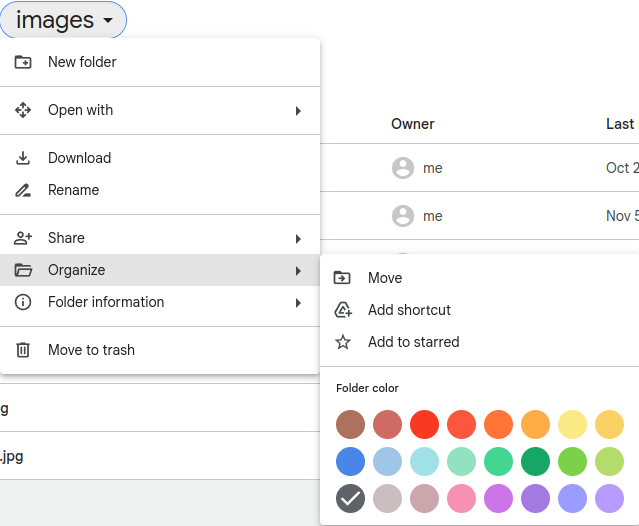


**3. Next click on "All locations" and select "My Drive". Then click "Add"**

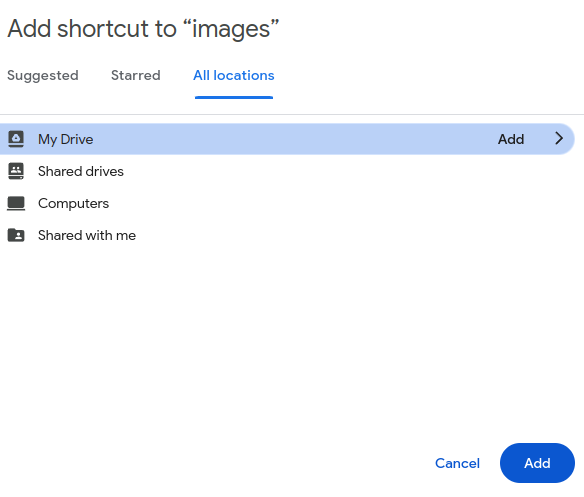

**4. To double-check that it was added correctly, go to your drive:**
https://drive.google.com/drive/u/0/my-drive
**Make sure there is a folder called "Images"**



**5. Finally, run the code below to mount your drive. Give it all the permissions that it asks for.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Opencv (called cv2) can read images and make manipulations to them.<br>
**6. Run the code below. You should see an image of a bee.**<br>
If you get this error:
AttributeError: 'NoneType' object has no attribute 'clip'
Make sure that you actually have the folder in your Google Drive and mounted the drive properly.

In [ ]:
img = cv2.imread("/content/drive/MyDrive/images/example/bee1.jpg")

cv2_imshow(img)

## Part 1: What is an image?
To the computer, images are just arrays.  
- A black and white image is a single 2D array
- Color images are 2D arrays with multiple channels, which are multiple 2D arrays displayed together
- The three color channels in a typical color image are red, green and blue. Together they make most colors a human can see
- Each color value typically range between 0-255 (256 = 2^8 values)
- There are other ways to represent an image, which we will get into later.

<b>7. Run the next block of code to see what the computer "sees" the image as.</b>

In [ ]:
print(img)

As you can see, the computer sees an image as just bunch of numbers.



<b>8. Edit the code to make the colors of the image. i.e. change (0,0,0) to the color specified.</b>

Use https://teamcolorcodes.com/purdue-boilermakers-colors/ as a reference for what colors correspond to what.

Note: OpenCV uses B,G,R format. Most other places use R,G,B format. You just need to switch the first and last value This is especially important for picking the gold color.

In [ ]:
secret_img = cv2.imread("/content/drive/MyDrive/images/example/secret_img.png", 0)
new_img = np.zeros((secret_img.shape[0], secret_img.shape[1], 3), np.uint8)

new_img[secret_img==0] = (0,0,0) # white
new_img[secret_img==1] = (0,0,0) # gray
new_img[secret_img==2] = (0,0,0) # black
new_img[secret_img==3] = (0,0,0) # Athletic gold

cv2_imshow(new_img)


# Part 2: Finding Bees

The most simple way of separating something from its background is finding the approximate color of the background and removing it. Try dong this to an image of a bee.<br><br>
<b>9. Try finding masking third (red) lower threshold value to remove the most of the background.</b><br>
 <br>Start at 0 and work your way up. The result should look something like this:<br><br>
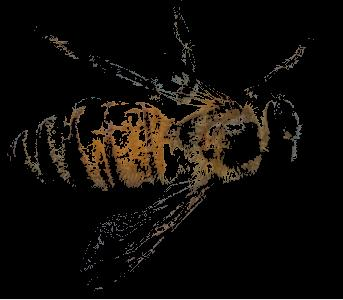

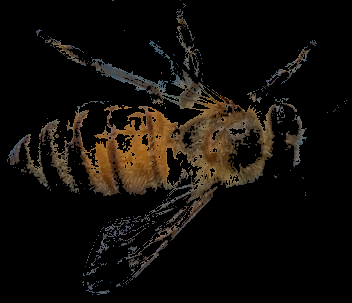

In [ ]:
lowerThresh = np.array([0,0,0]) # change third threshold value to something between 0-255
upperThresh = np.array([120,120,255])

mask = cv2.inRange(img, lowerThresh, upperThresh)
res = cv2.bitwise_and(img, img, mask=mask) # make everything outside the threshold black
cv2_imshow(res)

Removing the background was hard using the BGR color format. Fortunately there are better ways to do it.

<b>10. Modify the upper hue threshold to get rid of the background.</b><br>
- This is using HSV, or hue, saturation and value. It separates color, so it should be much easier to eliminate the blue background.
- Try to eliminate most of the background. Start at 255 and work your way down
- We will be using this function in future steps.<br>The end result should look something like this:<br>
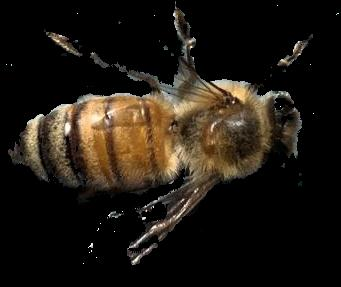

In [ ]:
def hsvThreshold(img):
	hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert image to HSV
	# cv2_imshow(hsv)

	lowerThresh = np.array([0,20,30])
	upperThresh = np.array([0, 200, 255]) # change first threshold value to something between 0-255
	mask = cv2.inRange(hsv, lowerThresh, upperThresh)
	res = cv2.bitwise_and(img, img, mask= mask) # make everything outside the threshold black

	return res
cv2_imshow(hsvThreshold(img))

**11. Run the code below. Don't change anything**

This will try to do the same thresholding, but on an image with the bee on a wooden board. It probably did not do a very good job at making the background black. A method other than thresholding is necessary.

In [ ]:
bee_on_board = cv2.imread("/content/drive/MyDrive/images/example/bee_on_board.png")
cv2_imshow(hsvThreshold(bee_on_board))

Since the background removal function doesn't work well with backgrounds similar to the bee's color, let's look at other options.<br>
<b>12. Modify the two canny thresholds to have many lines where the bee is, and have few lines elsewhere.</b><br>
- OpenCV's Canny edge detection attempts to detect edges in the image.
- We will try to detect distinguish between the bee (many color variations/edges) from the background (fewer color variations)
- Start at 1000 and work your way down to zero. The two numbers will probably end up between 100 and 300.
- Next, the function will dilate the edges and turn the edges into approximate shapes. <br>

In [ ]:
def detectCanny(img):
  thresh1 = 1000 # change threshold
  thresh2 = 1000 # change threshold
  canny = cv2.Canny(img, thresh1, thresh2) # create canny lines
  cv2_imshow(canny)
  print("")
  kernel = np.ones((5, 5))
  canny = cv2.dilate(canny, kernel, 1) # make lines wider

  img[canny < 20] = 0 # remove areas without the canny lines from the image

  return img


cv2_imshow(detectCanny(bee_on_board.copy()))

# Part 3: Using Machine Learning


The above sections only works in certain conditions and you need to manually find thresholds for colors and edges. Since finding thresholds is hard, you can't do any complicated pattern detection.

With machine learning, the computer looks at example images and tries to find patterns that can be applied to new images.

The first step in supervised machine learning is getting data that the computer can use for training.



**13. Annotate the bee image** <br>

a. Download the image folder from here and **unzip** it: https://drive.google.com/drive/folders/1rRjU9nWkKGpK8OWYwWQtllL7f8soXazo?usp=drive_link

b. Go to this website: https://agr333.netlify.app/

c. Click the "**Import: Choose files**" button and click the path of the extracted image folder.

d. Click points and press the enter key to draw a polygon around the bee from the image of the bee with the blue background. It should look like this:<br>
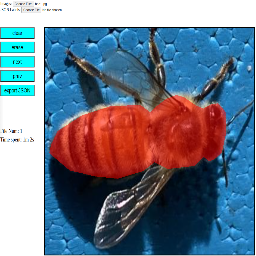

e. You should make a polygon around the body of the bee. Don't make a polygon around the wings or legs.

f. When done, click the "**Export JSON**" button. It should download a file called "data.JSON".

g. Put that data.JSON file in the **home folder of your Google drive**
<br>

**CHECKPOINT: Make sure that you are using the Google Colab GPU at this point. Everything will still work with the CPU, but it may take hours to run some sections of code.**

**14. Run the code below.** If it says "cuda:0", you are good to go.
If it says "cpu", you are using the wrong runtime environment.

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)



**15. To get things set up, run this code.** No need to look at or change this code.
These are just functions and libraries to put the images in the right format. It might take a few seconds to run and ask you to connect to the drive again.

In [ ]:
# @title Run this code

import numpy as np
from google.colab.patches import cv2_imshow
import os
import cv2
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.utils.data as data
from torchvision import transforms, datasets, models
import torch.nn.functional as F
import time
from PIL import Image
import torch.optim as optim
import matplotlib.patches as mpatches
from collections import defaultdict


from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def get_mask(img, polygons):
  mask = np.zeros((img.shape[0:2]), np.uint8)

  for poly in polygons:
    if len(poly) > 3:
      newPoly = []
      for p in poly[0:-1]:
        newPoly.append([int(p[0]), int(p[1])])
      if poly[-1] == 0:
        cv2.fillPoly(mask, pts = [np.array(newPoly)], color=255)
      else:
        cv2.fillPoly(mask, pts = [np.array(newPoly)], color=0)
  return mask

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def cv2_to_tensor(img):
  pil_image = Image.fromarray(img)

  pil_image = train_transform(pil_image)
  pil_image = pil_image.unsqueeze(0)
  return pil_image.to(device)



def load_imgs_masks_from_json(json_path, image_path):
  images = []
  masks = []
  with open(json_path) as json_file:
    json_data = json.load(json_file)

  for img_name in json_data:
    if img_name in os.listdir(image_path):
      img = cv2.imread(os.path.join(image_path, img_name))
      mask = get_mask(img, json_data[img_name])
      images.append(cv2.resize(img, (160,160)))
      masks.append(cv2.resize(mask, (160,160)))
  return images, masks


def load_imgs_masks_imgs(path, count=-1):
  i=0
  images = []
  masks = []
  for img_name in os.listdir(path):
    if img_name[-4::] == ".png" and "mask" not in img_name:
      img = cv2.imread(os.path.join(path, img_name))
      a = img_name.split("_")
      print(a)

      mask = cv2.imread(os.path.join(path, a[0] + "_mask.png"), 0)
      images.append(cv2.resize(img, (160,160)))
      masks.append(cv2.resize(mask, (160,160)))
      i+=1
      if count > 0 and i > count:
        break
  return images, masks


def load_imgs_masks_imgs(path, count=-1):
  # not using this because google drive is really slow for many images
  i=0
  images = []
  masks = []
  for img_name in os.listdir(path):
    if img_name[-4::] == ".png" and "mask" not in img_name:
      img = cv2.imread(os.path.join(path, img_name))
      a = img_name.split("_")
      print(a)

      mask = cv2.imread(os.path.join(path, a[0] + "_mask.png"), 0)
      images.append(cv2.resize(img, (160,160)))
      masks.append(cv2.resize(mask, (160,160)))
      i+=1
      if count > 0 and i > count:
        break
  return images, masks

def load_imgs_masks_vid(path, count=-1):
  cap_img = cv2.VideoCapture(os.path.join(path, "images.avi"))
  cap_mask = cv2.VideoCapture(os.path.join(path, "masks.avi"))
  i=0
  images = []
  masks = []
  while True:
    ret, img = cap_img.read()
    ret2, mask = cap_mask.read()
    if not ret or not ret2:
      break
    images.append(img)
    masks.append(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY))
    if i > count and count > 0:
      break
    i+=1
  return images, masks





def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()



def calc_loss(pred, target, metrics, bce_weight=0.5):
    metrics
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    return loss


class Dataset(data.Dataset):
    def __init__(self, images, masks, augment=False):
        self.images = images
        self.masks = masks
        self.augment = augment
        self.img_size = 160

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
      flipLR = False
      flipTB = False
      if self.augment:
        flipLR=np.random.random() > 0.5
        flipTB=np.random.random() > 0.5


      mask = self.masks[index].copy()
      if flipLR:
          mask = cv2.flip(mask, 0)
      if flipTB:
          mask = cv2.flip(mask, 1)
      mask = cv2.resize(mask, (self.img_size, self.img_size))
      mask = mask / 255.0
      mask = torch.from_numpy(mask)


      image = self.images[index].copy()
      if flipLR:
          image = cv2.flip(image, 0)
      if flipTB:
          image = cv2.flip(image, 1)
      image = train_transform(image)

      return image, mask


def show_random_test(model, images):
  max_ind = len(images)-1
  if max_ind > 0:
    img_test = images[np.random.randint(0,max_ind)].copy()
  else:
    img_test = images[0].copy()
  with torch.no_grad():
    output = model(cv2_to_tensor(img_test).to(device))
  res =  torch.nn.functional.sigmoid(output)
  resImg = (res.cpu().detach().numpy()*255).astype(np.uint8)[0, :, :][0, :, :]

  img_masked = img_test.copy()
  img_masked[resImg<128] = 0
  img_show = np.hstack((img_test, img_masked))

  cv2_imshow(img_show)



def train_epoch(model, optimizer, data_loader, val_loader=None):
  metrics = defaultdict(float)
  epoch_losses = []
  for imgs in data_loader:
    imgs_input = imgs[0].to(device)
    imgs_target = imgs[1].unsqueeze(0).to(device)
    outputs = model(imgs_input)
    loss = calc_loss(outputs, imgs_target, metrics)

    optimizer.zero_grad()
    loss.backward()
    epoch_losses.append(float(loss))
    optimizer.step()

  metrics = defaultdict(float)
  val_losses = []
  if val_loader is not None:
    with torch.no_grad():
      for imgs in val_loader:
        imgs_input_val = imgs[0].to(device)
        imgs_target = imgs[1].unsqueeze(0).to(device)
        outputs_val = model(imgs_input_val)
        loss = calc_loss(outputs_val, imgs_target, metrics)
        val_losses.append(float(loss))
      val_loss = sum(val_losses)/len(val_losses)
  else:
    val_loss = 0

  train_loss = sum(epoch_losses)/len(epoch_losses)

  return train_loss, val_loss


**16. Once done, run this code to check if your annotations are correct.** No need to change any code. You should see the bee with the background blacked out, like this:

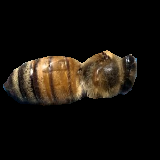

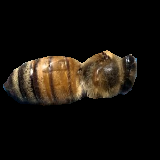

In [ ]:
json_path = "/content/drive/MyDrive/data.JSON"
image_path = "/content/drive/MyDrive/images/example"

if "data.JSON" in os.listdir("/content/drive/MyDrive/"):

  images, masks = load_imgs_masks_from_json(json_path, image_path)

  bee1 = images[0]
  bee1_mask = masks[0]

  # shows first bee image
  test=bee1.copy()
  test[bee1_mask==0] = 0
  cv2_imshow(test)
else:
  print("Error: You did not add the data.JSON file")


## Clustering

One simple machine learning technique is k-Nearest Neighbors (kNN).

**17. Run the code to see a plot of the colors associated with the bee and background.**

In [ ]:
bee1_hsv = cv2.cvtColor(bee1, cv2.COLOR_BGR2HSV)
bee1_rgb = cv2.cvtColor(bee1, cv2.COLOR_BGR2RGB)

pixels = bee1_hsv[bee1_mask!=0]
rgb_colors = bee1_rgb[bee1_mask!=0] / 255


pixels_bg = bee1_hsv[bee1_mask==0]
rgb_colors_bg = bee1_rgb[bee1_mask==0] / 255


hue = pixels[:, 0]
value = pixels[:, 2]

plt.scatter(hue, value, color=rgb_colors, s=0.1)
plt.title("Colors of the bee")
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.show()

hue = pixels_bg[:, 0]
value = pixels_bg[:, 1]

plt.scatter(hue, value, color=rgb_colors_bg, s=0.1)
plt.title("Colors of the background")
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.show()

If you did the annotations correct, you should see many more brown pixels on the left side of the first plot, and many more blue pixels on the right side of the second plot.

The image has three channels (red, green, blue) but the plot can only show two of the channels.

**18. Run the code to train the kNN model** No need to change anything. Once it is finished it will output a blue box, and that's it.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score


# Create labels
labels1 = np.zeros((pixels.shape[0],))
labels2 = np.ones((pixels_bg.shape[0],))

# Combine the datasets
X = np.vstack((pixels, pixels_bg))
y = np.concatenate((labels1, labels2))

X = np.vstack((pixels[:, :2], pixels_bg[:, :2]))
y = np.concatenate((np.zeros(len(pixels)), np.ones(len(pixels_bg))))


X_full = np.vstack((pixels, pixels_bg))
y_full = np.concatenate((np.zeros(len(pixels)), np.ones(len(pixels_bg))))


# Create a kNN classifier instance
# You can change the value of 'n_neighbors' based on your requirement
knn = KNeighborsClassifier(n_neighbors=100)

# Train the classifier
knn.fit(X, y)


knn_full = KNeighborsClassifier(n_neighbors=100)
knn_full.fit(X_full, y_full)


KNeighborsClassifier(n_neighbors=100)

Once it finished training, plot out the decision boundary.

**19. Run the code. No need to change anything** It may take a while to plot everything.

The plot shows the decision boundary for the colors. If a pixel color falls on the light blue color, it is classified as a bee pixel. If the pixel color falls on the light tan color, it is a background pixel.

In [ ]:
# Create a meshgrid for plotting
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))



# Predict classifications for each point in the meshgrid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary using contour plot
plt.contourf(xx, yy, Z, alpha=0.3)

# Plot the original data points
plt.scatter(pixels[:, 0], pixels[:, 1], color='red', label='Bee', s=0.01)
plt.scatter(pixels_bg[:, 0], pixels_bg[:, 1], color='blue', label='Background', s=0.01)


class1_patch = mpatches.Patch(color='red', label='Bee')
class2_patch = mpatches.Patch(color='blue', label='Background')
class1_boundary = mpatches.Patch(color=(199/255, 186/255, 210/255), label='Bee pred')
class2_boundary = mpatches.Patch(color=(240/255, 245/255, 186/255), label='Background pred')

# Adding labels and title
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title('kNN Decision Boundary with Two Dimensions')
plt.legend(handles=[class1_patch, class2_patch, class1_boundary, class2_boundary])

# Show the plot
plt.show()

Now test the kNN classifier on the real bee image.

**20. Run the code below to get a prediction. Don't change anything.** The result should look similar to the HSV color thresholding prediction. It may take a few seconds to run. Probably easier and more accurate than tuning the thresholds yourself!

In [ ]:
# Reshape the image to be a list of pixels
pixels = bee1_hsv.reshape((-1, 3))

# Predict the class for each pixel
predicted_classes = knn_full.predict(pixels)

# Reshape the predictions back to the original image shape (only one channel)
predicted_mask = (1-predicted_classes.reshape(bee1_hsv.shape[:2])) * 255

bee_img_copy = bee1.copy()
bee_img_copy[predicted_mask<50] = 0
cv2_imshow(bee_img_copy)

Now test the kNN on a bee image with a different background color.

**21. Run this code**. No need to change anything.<br> It is probably not very good at finding the bee.

In [ ]:
bee_real = cv2.resize(cv2.imread("/content/drive/MyDrive/images/validation/test1.png"), (320, 320))
bee_real_hsv = cv2.cvtColor(bee_real, cv2.COLOR_BGR2HSV)
# Reshape the image to be a list of pixels
pixels = bee_real_hsv.reshape((-1, 3))

# Predict the class for each pixel
predicted_classes = knn_full.predict(pixels)

# Reshape the predictions back to the original image shape (only one channel)
predicted_mask = (1-predicted_classes.reshape(bee_real_hsv.shape[:2])) * 255

bee_img_copy = bee_real.copy()
bee_img_copy[predicted_mask<50] = 0
cv2_imshow(bee_img_copy)

### Part 4 Neural Networks

While kNNs might work for images with a clear difference in background, it doesn't work well in most other situations. Neural networks work much better in a variety of situations and are more popular.


Neural networks have are a type of deep learning, where it performs linear algebera operations, "activates" some of the results, and then performs more linear algebra operations. This helps it recognize patterns, and can be repeated multiple times.

There are many types of neural networks, such as:
- Classifier (like smartphone Face ID)
- Generative (like ChatGPT)
- Object detector (like security camera detections)
- Segmentation (like finding bees in this lab)

A convolutional layer is one type of layer that is useful for finding things in  images. There are other kinds of neural network layers for other applications. It takes the dot product (a linear algebra operation) between the kernel and smaller sections of the image throughout the image. The values of the kernel determine what the neural network is able to detect.

Here is a graphic of how convolutions work:<br>
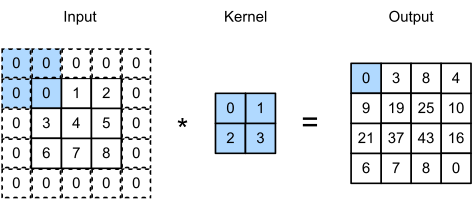

For the blue boxes, the top left of the input is multiplied by the top left of the kernel, the top right multiplied by the top right, and so on. Then everything is added together, and that is the value of the top left of the output. For example the calculation in the blue boxes is 0x0 + 0x1 + 0x2 + 0x3 = 0

You then look at the next pixel over for the convolution and repeat the process.


Afterwards, an extra number is added to the each value of result, called a *bias*.


Each number in that result is often called a neuron, since it activates just like a brain. To activate the neuron an *activation function* is applied. Depending on the value of the result, the number may "activate". Activation functions typically do simple things, like make the number a 0 or 1.

The process of applying a convolutional layer and then applying the activation function can be repeated over and over, which lets the neural network find patterns well.


To start, below is code for a simple neural network with one convolutional layer. The activation function used in this network is the sigmoid function, which will make the number close to 0 if the number is less than 0, and make the number close to 1 if the number is more than 1. Neurons that are 1 are considered activated. The goal for this project is to have bee pixels activate, and background pixels not activate.


**22. Try changing the values of the kernal and bias to make the bee white and the background black**
Try making the bee stand out while still having the accuracy be at least 55%

Hint: Make the blue and green values between 0 and 1, and the red values between -1 and 0. The bias should be between -1 and 0.

In [ ]:

# change the kernel values
kernel = np.array([[
          [[0, 0, 0], # red
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0], # green
          [0, 0, 0],
          [0, 0, 0]],

          [[0, 0, 0], # blue
          [0, 0, 0],
          [0, 0, 0]],

         ]])

bias = 0 #change the bias too

def convolve2d(image, kernel, bias, padding=0):

    kernel_height, kernel_width = kernel.shape[2], kernel.shape[3]
    image_height, image_width = image.shape[0], image.shape[1]

    # Add padding to the image
    padded_image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant')

    # Calculate the dimensions of the output image
    output_height = image_height - kernel_height + 1 + 2 * padding
    output_width = image_width - kernel_width + 1 + 2 * padding
    output = np.zeros((output_height, output_width))

    # Perform convolution
    for y in range(output_height):
        for x in range(output_width):
            conv_sum = 0  # Initialize sum for convolution
            for c in range(3):  # 3 channels in the image
                conv_sum += np.sum(padded_image[y:y + kernel_height, x:x + kernel_width, c] * kernel[0, c, :, :]) # do the dot product
            output[y, x] = conv_sum + bias  # Add the bias term


    return output

# shrink the image (to make it run faster)
input = cv2.resize(bee1, (128,128))

output = convolve2d(input, kernel, bias, 1)

# apply the sigmoid activation function
output = 1 / (1 + np.exp(-output)) * 255

output[output < 128] = 0
output[output > 127] = 255

output_color = cv2.cvtColor(output.astype(np.uint8), cv2.COLOR_GRAY2BGR)

cv2_imshow(np.hstack((input, output_color)))

small_mask = cv2.resize(bee1_mask, (128, 128), interpolation=cv2.INTER_NEAREST)

accuracy = np.sum(output==small_mask) / (128*128)
print("% of correct pixels:", accuracy)

Manually adjusting the combinations of many numbers by hand is hard and slow. Computers are much faster at doing this.

The computer does this by guessing and checking. The computer corrects the values of the parameters based on how "wrong" its prediction was. The error that the computer tries to minimize is called *loss*.

**23. Run the code below. Don't change anything.** It will train the same convolutional layer by adjusting the values of the kernel and bias.

In [ ]:
img_train = cv2_to_tensor(cv2.resize(bee1, (128, 128))).to(device)

img_target = cv2_to_tensor(cv2.resize(bee1_mask, (128, 128)))[:, 0,:,:].unsqueeze(0).to(device)

class SimpleSegmentationNet(nn.Module):
    def __init__(self):
        super(SimpleSegmentationNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x


losses = []
net = SimpleSegmentationNet().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()
showCount = 0
for epoch in range(10001):
    output = net(img_train)
    loss = criterion(torch.nn.functional.sigmoid(output), img_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        losses.append(float(loss))
    # if epoch % 10**showCount == 0: # show the image. Uncomment if you'd like.
    #     res =  torch.nn.functional.sigmoid(output)
    #     resImg = (res.cpu().detach().numpy()*255).astype(np.uint8)[0, :, :][0, :, :]
    #     cv2_imshow(resImg)
    #     print("epoch", epoch, "loss", float(loss))
    #     showCount+=1



plt.plot( np.arange(len(losses))*100, losses)
plt.title("Training Loss")
plt.xlabel("Epoch (times the computer looked at the image)")
plt.ylabel("Loss (Error)")
plt.show()

weights = net.state_dict()["conv.weight"]
bias = net.conv.bias.data
print("weights", weights)
print("bias", bias)

You should see two things:
  1. A plot of the training loss. Each time the computer does the guess-check-correct process is an epoch.
  2. The weights and biases.

**24. Copy the weights and bias printed out, and replace the weights you manually picked from step 22.**

**25. Run the code from that step.**

The numbers picked from the training process likely have better accuracy than the numbers you chose.

**26. Run the code to test the model on bees with a less obvious background**

The model will probably not work well for the bees on the honeycomb.

In [ ]:
bee_real = cv2.resize(cv2.imread("/content/drive/MyDrive/images/validation/test1.png"), (160, 160))

print("\nbees on honeycomb")
show_random_test(net, [bee_real])



The model above did not work very well on the honeycomb image for the following reasons:


1.   The model was trained on a single image, with a bright blue background. Therefore the neural network only was good at detecting the specific bee used for training.
2.   The model was overfitting. Usually you train the model for 10-100 epochs. this model was trained for 10000 epochs. This means the model "memorized" the training data.
3.   The model is too simple. Just like the kNN trained earlier, it was basically only able to look for colors.

**27. To improve the model, start by annotating a few more images:**

a. Download and unzip this folder to your own computer: https://drive.google.com/drive/folders/1NXlq8aB1TfHbTJwp-xGYlGyqdyr4-lJm?usp=sharing

b. Go back to the annotation tool: https://agr333.netlify.app/

c. Annotate the images the same way as before. You should be annotating 6 images. Make polygons around the bees, excluding the wings and legs. Annotate all the bees in the image, even if they are cut off, like this:<br>
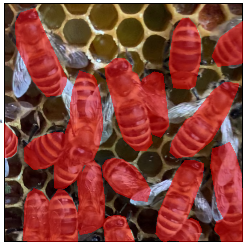

d. When done annotating, click "**Download JSON**". Rename that file to "**data2.JSON**"

e. Move that json file that you downloaded to the **home folder of your Google Drive**. (Where you saved the first json file)

f. **Record/remember the time it took for you to annotate all of the images.** There is a question about about it at the end of this lab.
<br><br>
**28. Run this code to check that the annotations are right. No need to change anything here**. It should show the bees without the background.

In [ ]:
json_path = "/content/drive/MyDrive/data2.JSON"
image_path = "/content/drive/MyDrive/images/imgs_annotate"

train_imgs, train_masks = load_imgs_masks_from_json(json_path, image_path)


for img, mask in zip(train_imgs, train_masks):
  im = img.copy()
  im[mask==0] = 0
  cv2_imshow(np.hstack((img, im)))

train_set = Dataset(train_imgs, train_masks, augment=True)
train_loader = data.DataLoader(train_set, batch_size=1, shuffle=True)


# also load in validation data here. No need to change anything about this. Will use later on in lab.
val_path = "/content/drive/MyDrive/images/validation"
val_path_json = "/content/drive/MyDrive/images/validation/data.JSON"
val_imgs, val_masks = load_imgs_masks_from_json(val_path_json, val_path)
val_set = Dataset(val_imgs, val_masks, augment=False)
val_loader = data.DataLoader(val_set, batch_size=1, shuffle=True)

**29. Now run this code to train the model again. Don't change anything**

This should load the new images you annotated. It will train the same model as before, and show the results.

In [ ]:
net = SimpleSegmentationNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(100):
  train_loss, _ = train_epoch(net, optimizer, train_loader)
  if epoch%10 == 0:
    print("epoch", epoch, "train loss", train_loss)

print("From training data:")
show_random_test(net, train_imgs)

print("\nFrom testing data")
show_random_test(net, val_imgs)

Even though you gave it a few more images, and they did not have obvious backgrounds, the model still performed poorly.


#### Making Your Own Neural Network
The values for the kernel and bias are called *parameters*, which are adjusted by the computer.
While you don't normally adjust the parameters yourself, you can control what the computer learns and how the computer learns.

It doesn't matter how good a model is at making predictions on the images the model was trained on. What matters is the model's ability to make predictions on new, unseen data. To make sure that the model can perform well on unseen data, you use *validation data*.

*Validation data* are images that you don't train with, but you check the model's performance on as you train. If the accuracy of the model on training data is good but the validation accuracy is bad, that means the model is overfitting, and you should change the model accordingly.

This means that from now on, the code when training will print out two losses: Training loss, and validation loss. If training loss is low (good) and validation loss is high (bad), then it means the model is bad at predicting on new images.

<br><br>


***Model layers (What the computer learns)***

The model used earlier was too simple, since it had only one layer. You can make the model better at finding patterns by adding more layers.


In the definition of the neural network, there is currently one layer, which looks like this:

```nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)```

* The ```in_channels=3``` is 3 because there are three colors (red, blue, green).

* The ```out_channels=1``` is 1 because you only want one color for the prediction (0=not bee, 1=bee).


Neural networks typically have layers between the input and output, which are called *hidden layers*. This is why neural networks are considered a type of *deep learning*.

You can add any number of layers between the input and output, as long as the channels in and channels out remains the same. You just need to make sure that the ```out_channels``` is the same as the next layer's ```in_channels```.


You also should add an activation function after each layer, except for the last. There are many types of activation functions, but for this lab use ```nn.ReLU()```

For example, if you wanted 2 hidden layers, with channels going from 3>16>32>1, it would look like this:


```
self.conv_layers = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
)
```

When choosing the number of layers, consider the following rules of thumb:
- Try making the number of channels increase, and then decrease as the layers progress. For example 3>16>32>16>1
- Try making the number of channels powers of 2 (2,4,8,16,32,64...). This is not required, but may make it a little more efficient.
- Making more layers will increase training time and improve its ability to find patterns
- Using fewer layers will decrease training time and make less likely to overfit.
<br><br>


***Hyperparameters: (How the computer learns)***

There are various things you can adjust to affect how the computer learns. The thing you can adjust for this lab are the number of *epochs*.

**Epochs** are how many times the computer "looks at" the images. Set the # of epochs to something between 20-200. Any more will take too long to train.

- If too many epochs, it will take a long time to train and it will overfit
- If too few epochs, it will not fit to either the training or validation data.


**30. Modify the number of layers and the number of epochs and train the model.**

Keep modifying until you get a training loss less than 0.4 and a validation loss less than 0.85.

*Note: If you have too many epochs or too many layers, it will take a super long time to train. Don't bother letting it train for more than a minute or two. If it does take longer, reduce the number of epochs.*

In [ ]:
num_epochs = 100  # number of epochs. Modify
test_frequency = 10 # change this to make it show a test image every XX epochs


class SegmentationNetToModify(nn.Module):
    def __init__(self):
        super(SegmentationNetToModify, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1),
            # add more nn.Conv2d layers here.
            # make sure the out_channels of the last layer is 1
            # remember to add a nn.ReLU() after each layer besides the last.
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return x




net = SegmentationNetToModify().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
losses = []
losses_val = []

start_time = time.time()
for epoch in range(num_epochs):
  train_loss, val_loss = train_epoch(net, optimizer, train_loader, val_loader)
  losses.append(train_loss)
  losses_val.append(val_loss)

  time_left = (time.time()-start_time) / (epoch+1) * (num_epochs-epoch-1)
  print("epoch", epoch+1, "/", num_epochs, "train loss", train_loss, "val loss:", val_loss, "ETA:", str(round(time_left, 2)), "s")

  if epoch % test_frequency == 0:
    print("Example train image prediction:")
    show_random_test(net, train_imgs)

    print("\nExample validation image prediction")
    show_random_test(net, val_imgs)

print("Final example train image prediction:")
show_random_test(net, train_imgs)

print("\nFinal example validation image prediction")
show_random_test(net, val_imgs)

print("model has", sum(p.numel() for p in net.parameters() if p.requires_grad), "trainable parameters")


plt.plot(losses)
plt.plot(losses_val)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train loss", "Validation loss"])
plt.show()

Even with a variety of layers, your neural network probably still doesn't do well on the validation data. This is because the 6 images for training still isn't enough.

**32. Run this code to load in 500 images that are already annotated for you.** Don't change anything

In [ ]:
train2_path = "/content/drive/MyDrive/images/imgs_train2"
# also load in validation data here. Will talk about later on in lab.
train2_imgs, train2_masks = load_imgs_masks_vid(train2_path, count=498)
print("loaded", len(train2_imgs), "images")
train2_set = Dataset(train2_imgs, train2_masks, augment=True)
train2_loader = data.DataLoader(train2_set, batch_size=1, shuffle=True)

i=0
for img, mask in zip(train_imgs, train_masks):
  im = img.copy()
  im[mask==0] = 0
  print()
  cv2_imshow(np.hstack((img, im)))

  i+=1
  if i == 4:
    break



**33. Now run the code to train the neural network that you made.** Since it is using 50x more images, it will take 50x longer. If it is going to take more than 5 minutes to train, stop and change the reduce of epochs.

In [ ]:
net = SegmentationNetToModify().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
losses = []
losses_val = []

# num_epochs =  # uncomment and adjust accordingly if it takes too long to train.

start_time = time.time()
for epoch in range(num_epochs):
  train_loss, val_loss = train_epoch(net, optimizer, train2_loader, val_loader)

  losses.append(train_loss)
  losses_val.append(val_loss)
  time_left = (time.time()-start_time) / (epoch+1) * (num_epochs-epoch-1)
  print("epoch", epoch+1, "/", num_epochs, "train loss", train_loss, "val loss:", val_loss, "ETA:", str(round(time_left, 2)), "s")

  if epoch % test_frequency == 0:
    print("Example train image prediction:")
    show_random_test(net, train_imgs)

    print("\nExample validation image prediction")
    show_random_test(net, val_imgs)

print("Final example train image prediction:")
show_random_test(net, train_imgs)

print("\nFinal example validation image prediction")
show_random_test(net, val_imgs)

plt.plot(losses)
plt.plot(losses_val)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train loss", "Validation loss"])
plt.show()

Hopefully the network performs a bit better on the validation images now.
<br>
<br>

While the neural network you made performed reasonably well, there are more fancy neural network layer techniques types that can perform better. For example, a model with only sequential convolutional layers will not perform well for images where some bees are up close and other bees are far away. One model architecture that is good at that sort of thing is called U-Net.

**34. Run the code below to define a U-Net model** No need to change anything, but take a look at the fancy layers of the model.

In [ ]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)
        return out


model = UNet(n_class=1).to(device)
print("model has", sum(p.numel() for p in model.parameters() if p.requires_grad), "trainable parameters")


**35. Now run the code to train and test the U-Net model.** No need to change anything. Even with the GPU it will probably take around 4 minutes.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
losses_val = []

test_frequency = 5
num_epochs = 20

start_time = time.time()
for epoch in range(num_epochs):
  train_loss, val_loss = train_epoch(model, optimizer, train2_loader, val_loader)

  losses.append(train_loss)
  losses_val.append(val_loss)
  time_left = (time.time()-start_time) / (epoch+1) * (num_epochs-epoch-1)
  print("epoch", epoch+1, "/", num_epochs, "train loss", train_loss, "val loss:", val_loss, "ETA:", str(round(time_left, 2)), "s")

  if epoch % test_frequency == 0:
    print("Example train image prediction:")
    show_random_test(model, train_imgs)

    print("\nExample validation image prediction")
    show_random_test(model, val_imgs)

print("Final example train image prediction:")
show_random_test(model, train_imgs)

print("\nFinal example validation image prediction")
show_random_test(model, val_imgs)
print("model has", sum(p.numel() for p in model.parameters() if p.requires_grad), "trainable parameters")

plt.plot(losses)
plt.plot(losses_val)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train loss", "Validation loss"])
plt.show()

It should be pretty good!
You are done with the lab. Now answer the questions in a word document to submit:

Questions

1. How many bytes is a 1080x1920 image with color, assuming no compression? Hint: Each pixel has 3 colors (RGB), and each color is one byte.

2. How many trainable parameters did the first convolutional neural network have (i.e. how many values did you try to change)?

3. What is the 4-letter word for error that a neural network tries to minimize?

4. In 1-2 sentences, describe how a typical neural network model's error changes as the it is being trained.

5. About how long did it take for you to annotate the 6 images? At that rate, how long would it take to annotate 1000 images?

6. For the neural network where you chose the layers:<br>
  3a. How many layers did you use?<br>
  3b. How many trainable parameters did the model have?<br>
  3c. How many epochs did you train it for?<br>
  3d. what was the train loss?<br>
  3e. what was the validation loss?

7. For the very last neural network you trained (the U-Net one):<br>
  3a. How many trainable parameters did the model have?<br>
  3b. what was the train loss?<br>
  3c. what was the validation loss?

